In [55]:
from datetime import datetime, timedelta
import xarray as xr
import cfgrib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Reading in HRRR Data (gridded fcst)

In [3]:
def object_fmt(init_time, sfc_or_prs, fcst_hr):
    part1 = f"hrrr.{init_time.strftime('%Y%m%d')}/conus/"
    part2 = f"hrrr.t{init_time.hour:02}z.wrf{sfc_or_prs}f{fcst_hr:02}.grib2"
    return part1 + part2

init_time = datetime(year=2021, month=1, day=1, hour=0)
fcst_hr = 18
bucket = "noaa-hrrr-bdp-pds"
sfc_or_prs = 'sfc' # sfc or prs
typeOfLevel = 'surface' if sfc_or_prs == 'sfc' else 'isobaricInhPa'
stepType = 'instant' # instant, max, or accum, but we only want instant
save_path = f"{init_time.strftime('%Y%m%d')}_f{fcst_hr:02}_{sfc_or_prs}.grib2"

ds = xr.open_dataset(save_path, engine='cfgrib', filter_by_keys={'stepType': stepType, 'typeOfLevel': typeOfLevel})
ds

/Users/joshuaelms/miniconda3/envs/mos/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


<xarray.Dataset> Size: 305MB
Dimensions:     (y: 1059, x: 1799)
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
    latitude    (y, x) float64 15MB ...
    longitude   (y, x) float64 15MB ...
    valid_time  datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Data variables: (12/36)
    vis         (y, x) float32 8MB ...
    gust        (y, x) float32 8MB ...
    sp          (y, x) float32 8MB ...
    orog        (y, x) float32 8MB ...
    t           (y, x) float32 8MB ...
    cnwat       (y, x) float32 8MB ...
    ...          ...
    cfnsf       (y, x) float32 8MB ...
    vbdsf       (y, x) float32 8MB ...
    vddsf       (y, x) float32 8MB ...
    blh         (y, x) float32 8MB ...
    lsm         (y, x) float32 8MB ...
    siconc      (y, x) float32 8MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2025-02-23T14:35 GRIB to CDM+CF via cfgrib-0.9.1...

### Reading in KBMG Observations (station target)

In [54]:
data = "kbmg.csv"
df = pd.read_csv(data, quotechar='"', skipinitialspace=True, header=0, delimiter=',', engine='python')
df = df[df["CALL_SIGN"].str.strip() == "KBMG"]
dt_tmp = df[["DATE", "TMP"]]
dt_tmp["DATE"] = pd.to_datetime(dt_tmp["DATE"]).dt.round("h")
dt_tmp = dt_tmp.values

clean_tmp = []
skip_val = "+9999,9"
for dt, tmp in dt_tmp:
    if tmp.strip() == skip_val:
        continue
    new_tmp = float(int(tmp.strip().split(",")[0])/10)
    clean_tmp.append([dt, new_tmp])
    
clean_tmp = np.array(clean_tmp)
obs = clean_tmp[:,1]

/var/folders/7c/vf07b98s6rl293f1cb6qjf240000gn/T/ipykernel_16478/1532203576.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_tmp["DATE"] = pd.to_datetime(dt_tmp["DATE"]).dt.round("h")


In [59]:
fake_grid_data = obs[:, np.newaxis]
fake_grid_data = (fake_grid_data + np.random.normal(1, 5, fake_grid_data.shape)).astype(np.float32).round(2)

### Fit from "gridded" fcst to target obs

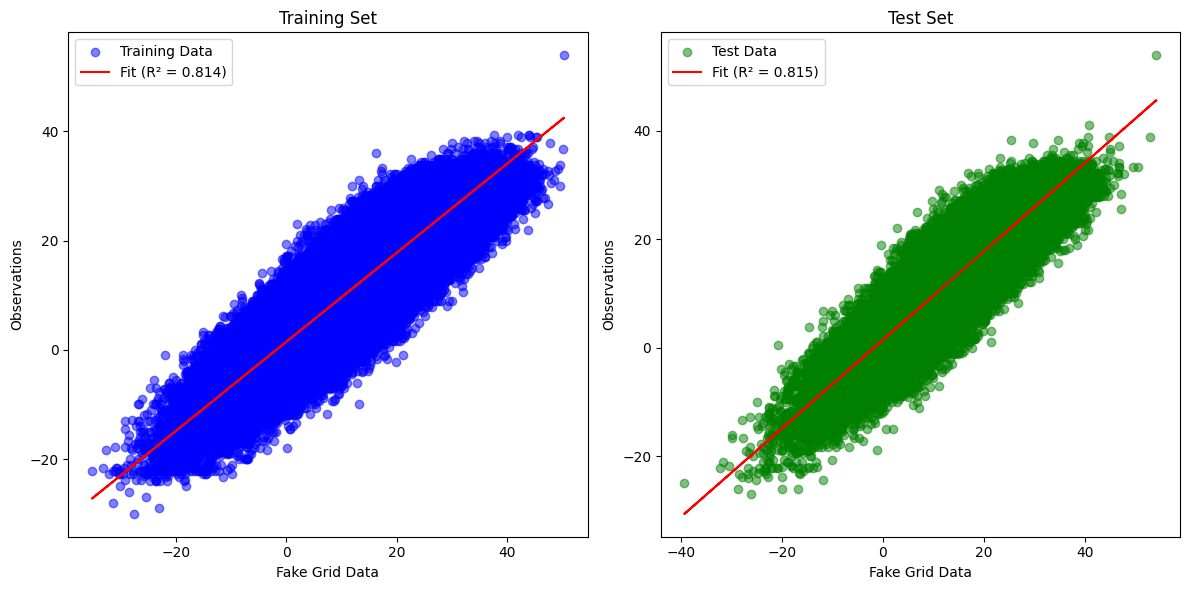

Model coefficients: bias = 1.4431, slope = 0.8148


In [60]:
# Split the data 80-20
X = fake_grid_data
y = obs
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform linear regression using numpy
X_train_b = np.c_[np.ones((X_train.shape[0], 1)), X_train]  # Add bias term
X_test_b = np.c_[np.ones((X_test.shape[0], 1)), X_test]     # Add bias term

# Calculate weights using normal equation
weights = np.linalg.inv(X_train_b.T @ X_train_b) @ X_train_b.T @ y_train

# Make predictions
y_train_pred = X_train_b @ weights
y_test_pred = X_test_b @ weights

# Calculate R-squared
train_r2 = 1 - np.sum((y_train - y_train_pred)**2) / np.sum((y_train - np.mean(y_train))**2)
test_r2 = 1 - np.sum((y_test - y_test_pred)**2) / np.sum((y_test - np.mean(y_test))**2)

# Create the plot
plt.figure(figsize=(12, 6))

# Training data
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train, color='blue', alpha=0.5, label='Training Data')
plt.plot(X_train, y_train_pred, color='red', label=f'Fit (R² = {train_r2:.3f})')
plt.xlabel('Fake Grid Data')
plt.ylabel('Observations')
plt.title('Training Set')
plt.legend()

# Test data
plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test, color='green', alpha=0.5, label='Test Data')
plt.plot(X_test, y_test_pred, color='red', label=f'Fit (R² = {test_r2:.3f})')
plt.xlabel('Fake Grid Data')
plt.ylabel('Observations')
plt.title('Test Set')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Model coefficients: bias = {weights[0]:.4f}, slope = {weights[1]:.4f}")